In [1]:
# Import all necessery python packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import re
import requests as req
from bs4 import BeautifulSoup
from urllib.parse import urljoin
from selenium import webdriver
import time
import geopy.distance
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import roman
import seaborn as sns
from fake_useragent import UserAgent

import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, RidgeCV, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from IPython.display import Image

sns.set()

%matplotlib inline

In [2]:
!ls

2013_movies.csv   Challenge 5.ipynb


In [5]:
df = pd.read_csv('2013_movies.csv')

In [6]:
df = df.apply(pd.to_numeric, errors='ignore')
df['ReleaseDate'] = df['ReleaseDate'].apply(pd.to_datetime, errors='ignore')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
Title                 100 non-null object
Budget                89 non-null float64
DomesticTotalGross    100 non-null int64
Director              96 non-null object
Rating                100 non-null object
Runtime               100 non-null int64
ReleaseDate           100 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 5.5+ KB


In [7]:
df.head()

,Title,Budget,DomesticTotalGross,Director,Rating,Runtime,ReleaseDate
0,The Hunger Games: Catching Fire,130000000.0,424668047,Francis Lawrence,PG-13,146,2013-11-22
1,Iron Man 3,200000000.0,409013994,Shane Black,PG-13,129,2013-05-03
2,Frozen,150000000.0,400738009,Chris BuckJennifer Lee,PG,108,2013-11-22
3,Despicable Me 2,76000000.0,368061265,Pierre CoffinChris Renaud,PG,98,2013-07-03
4,Man of Steel,225000000.0,291045518,Zack Snyder,PG-13,143,2013-06-14


#### Challenge 1

Build a linear model that uses only a constant term (a column of ones) to predict a continuous outcome (like domestic total gross). How can you interpret the results of this model? What does it predict? Make a plot of predictions against actual outcome. Make a histogram of residuals. How are the residuals distributed?

In [67]:
y = df['DomesticTotalGross']
X_const = pd.DataFrame(pd.Series(1 for _ in range(len(y))))

In [68]:
lr_const = LinearRegression(fit_intercept=False)
lr_const.fit(X_const,y)
print('Beta for the constant...',lr_const.coef_)
print('...is no better than predicting the mean of y', np.mean(y))

Beta for the constant... [1.00596875e+08]
...is no better than predicting the mean of y 100596875.22


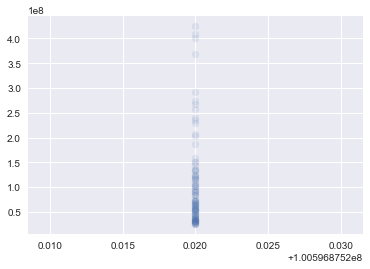

In [69]:
pred_const = lr_const.predict(X_const)
plt.scatter(pred_const,y,alpha=.1)

(array([47., 21., 15.,  3.,  3.,  4.,  3.,  0.,  1.,  3.]),
 array([-7.50286242e+07, -3.51186446e+07,  4.79133498e+06,  4.47013146e+07,
         8.46112942e+07,  1.24521274e+08,  1.64431253e+08,  2.04341233e+08,
         2.44251213e+08,  2.84161192e+08,  3.24071172e+08]),
 <a list of 10 Patch objects>)

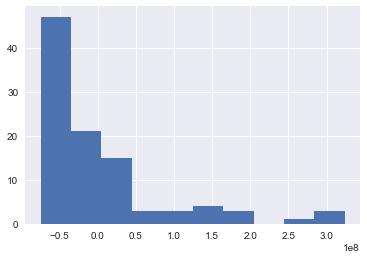

In [70]:
plt.hist(y-pred_const,alpha=1)
# residuals are maninly distributed around -.5, meaning most of the actuals are distributed closely around the mean
# but there are some large number outliers

#### Challenge 2

Repeat the process of challenge one, but also add one continuous (numeric) predictor variable. Also add plots of model prediction against your feature variable and residuals against feature variable. How can you interpret what's happening in the model?

In [71]:
y = df['DomesticTotalGross']
X_2 = pd.DataFrame({'constant': pd.Series(1 for _ in range(len(y))),
                        'Runtime': df['Runtime']
                       })
X_2.head()

,constant,Runtime
0,1,146
1,1,129
2,1,108
3,1,98
4,1,143


In [72]:
lr_2 = LinearRegression(fit_intercept=False)
lr_2.fit(X_2,y)
print('Coef:',lr_2.coef_)

Coef: [-57246774.20138394   1406054.24391042]


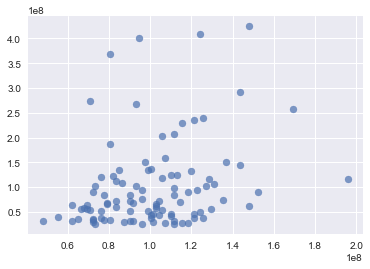

In [94]:
pred_2 = lr_2.predict(X_2)
plt.scatter(pred_2,y,alpha=0.7)

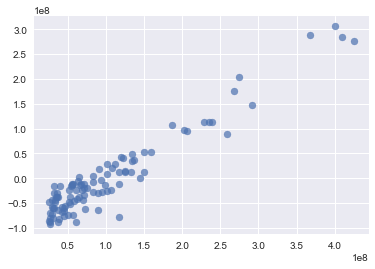

In [95]:
plt.scatter(y,y-pred_2,alpha=0.7)
# It is clear that there is a trend in the residuals, however for lower values we are not doing badly

#### Challenge 3

Repeat the process of challenge 1, but add a categorical feature (like genre). You'll have to convert a column of text into a number of numerical columns ("dummy variables"). How can you interpret what's happening in the model?

In [90]:
RATING_CAT = pd.get_dummies(df['Rating'], prefix='RATING_CAT')

y = df['DomesticTotalGross']
X_3 = pd.DataFrame({'constant': pd.Series(1 for _ in range(len(y))),
                    'Runtime': df['Runtime']
                       })
X_3 = pd.merge(X_3, RATING_CAT,left_index=True,right_index=True)
X_3.head()

,constant,Runtime,RATING_CAT_G,RATING_CAT_PG,RATING_CAT_PG-13,RATING_CAT_R
0,1,146,0,0,1,0
1,1,129,0,0,1,0
2,1,108,0,1,0,0
3,1,98,0,1,0,0
4,1,143,0,0,1,0


In [91]:
lr_3 = LinearRegression(fit_intercept=False)
lr_3.fit(X_3,y)
print('Coef:',lr_3.coef_)

Coef: [-2.80383585e+07  1.65718302e+06  1.19212539e+08 -6.43374901e+06
 -5.52485075e+07 -8.55686409e+07]


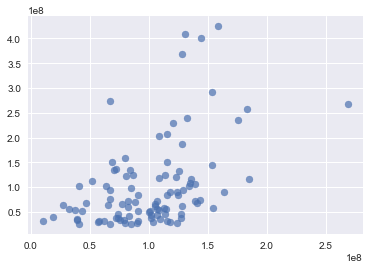

In [96]:
pred_3 = lr_3.predict(X_3)
plt.scatter(pred_3,y,alpha=0.7)
# Model is getting more accurate and is showing less bias

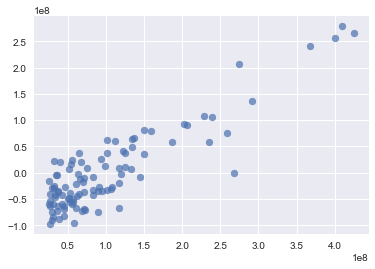

In [98]:
plt.scatter(y,y-pred_3,alpha=0.7)
# There is still a clear bias in the model

#### Challenge 4

Enhance your model further by adding more features and/or transforming existing features. Think about how you build the model matrix and how to interpret what the model is doing.

In [112]:
RATING_CAT = pd.get_dummies(df['Rating'], prefix='RATING_CAT')

y = df['DomesticTotalGross']
X_4 = pd.DataFrame({'constant': pd.Series(1 for _ in range(len(y))),
                    'Runtime': df['Runtime'],
                    'Budget': df['Budget']
                       })
X_4 = pd.merge(X_4, RATING_CAT,left_index=True,right_index=True)
X_4.fillna(0,inplace=True)

In [113]:
# To avoid overfitting, creating polynomial terms for selected columns only
# A: function to add second degree term
def add_square_terms(df, selected_columns):    
    
    df_poly = df.copy()
    
    for c in df.loc[:,selected_columns].columns:
        df_poly[c + '**2'] = df[c]**2
        
    return df_poly

def add_interaction_terms(df, selected_columns):    
    
    df_poly = df.copy()
    
    interactions = PolynomialFeatures(degree=2, interaction_only=True)
    
    X_inter = interactions.fit_transform(df_poly.loc[:,selected_columns])
    target_feature_names = ['x'.join(['{}^{}'.format(pair[0],pair[1]) for pair in tuple if pair[1]!=0]) for tuple in [zip(df_poly.columns,p) for p in interactions.powers_]]
    
    X_inter = pd.DataFrame(X_inter,columns=target_feature_names)
    df_poly = X_inter.join(df_poly.reset_index())
    
    df_poly.drop(df_poly.columns[range(0, len(selected_columns)+1)], axis=1, inplace=True)
    del df_poly['index']
    
    return df_poly

In [121]:
# Select columns to apply 2nd degree polynomial on
selected_columns_second_degree = ['Runtime', 'Budget']

# Apply interatcions on all columns, and 2nd degree on selected columns
X_4_poly = add_interaction_terms(add_square_terms(X_4,selected_columns_second_degree),list(X_4.columns))

# Run linear regression on the transformed
lm_poly = LinearRegression()
lm_poly.fit(X_4_poly, y)

# Predict on the model
pred_4 = lm_poly.predict(X_4_poly)

# List the coefficients
#list(zip(X_4_poly.columns,lm_poly.coef_))

In [122]:
# Apply LASSO to limit nr of features

scaler = StandardScaler()
X_4_poly_scaled = scaler.fit_transform(X_4_poly)

lr_model_lasso = LassoCV(n_alphas=100, cv=5)

lr_model_lasso.fit(X_4_poly_scaled,y)

pred_lasso = lr_model_lasso.predict(X_4_poly_scaled)
#list(zip(X_4_poly.columns,lr_model_lasso.coef_))

/Users/krisztian/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/krisztian/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/krisztian/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/krisztian/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Obje

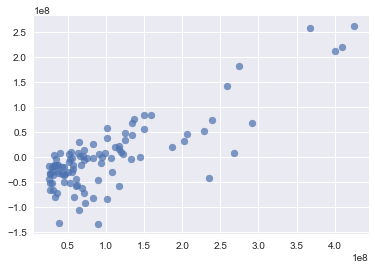

In [123]:
plt.scatter(y,y-pred_lasso,alpha=0.7)
# Less bias in the model

#### Challenge 5

Fitting and checking predictions on the exact same data set can be
misleading. Divide your data into two sets: a training and a test set
(roughly 75% training, 25% test is a fine split). Fit a model on the
training set, check the predictions (by plotting versus actual values)
in the test set.

/Users/krisztian/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/krisztian/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/krisztian/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/krisztian/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Obje

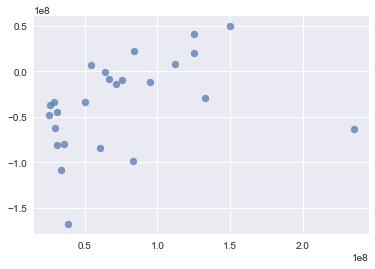

In [124]:
# Create the total dataframe
RATING_CAT = pd.get_dummies(df['Rating'], prefix='RATING_CAT')

y = df['DomesticTotalGross']
X_4 = pd.DataFrame({'constant': pd.Series(1 for _ in range(len(y))),
                    'Runtime': df['Runtime'],
                    'Budget': df['Budget']
                       })
X_4 = pd.merge(X_4, RATING_CAT,left_index=True,right_index=True)
X_4.fillna(0,inplace=True)

# Apply train-test-split
X_train, X_test, y_train, y_test = train_test_split(X_4, y, test_size=0.25)

# Select columns to apply 2nd degree polynomial on
selected_columns_second_degree = ['Runtime', 'Budget']

# Apply interatcions on all columns, and 2nd degree on selected columns
X_train_poly = add_interaction_terms(add_square_terms(X_train,selected_columns_second_degree),list(X_train.columns))
X_test_poly = add_interaction_terms(add_square_terms(X_test,selected_columns_second_degree),list(X_test.columns))

# Apply LASSO to limit nr of features
scaler = StandardScaler()
X_train_poly_scaled = scaler.fit_transform(X_train_poly)
X_test_poly_scaled = scaler.fit_transform(X_test_poly)

lr_model_lasso = LassoCV(n_alphas=100, cv=5)

lr_model_lasso.fit(X_train_poly_scaled,y_train)

pred_lasso = lr_model_lasso.predict(X_test_poly_scaled)

plt.scatter(y_test,y_test-pred_lasso,alpha=0.7)
# Clearly not the best model, biased at lower numbers

---

### Linear Regression and Learning Curve challenges


##### Challenge 1

Generate (fake) data that is linearly related to `log(x)`.

You are making this model up. It is of the form `B0 + B1*log(x) + epsilon`. (You are making up the parameters.)

Simulate some data from this model.

Then fit two models to it:

 * quadratic (second degree polynomial)
 * logarithmic (`log(x)`)

(The second one should fit really well, since it has the same form as the underlying model!)

In [126]:
import random

In [152]:
X = pd.DataFrame(pd.Series(random.randint(1,100) for _ in range(1000)))
y = pd.DataFrame(5+np.log(X)+random.random())

In [153]:
lr = LinearRegression()
lr.fit(X,y)

pred = lr.predict(X)

print('Coef:',lr.coef_, 'Intercept',lr.intercept_)
print('RMSE',np.sqrt(mean_squared_error(y, pred)),'MAE', mean_absolute_error(y,pred))
print('R^2:', lr.score(X, y))

Coef: [[0.02805286]] Intercept [8.02942404]
RMSE 0.40782562827029045 MAE 0.28283921392948413
R^2: 0.8019857562160497


In [155]:
X = X**2

lr = LinearRegression()
lr.fit(X,y)

pred = lr.predict(X)

print('Coef:',lr.coef_, 'Intercept',lr.intercept_)
print('RMSE',np.sqrt(mean_squared_error(y, pred)),'MAE', mean_absolute_error(y,pred))
print('R^2:', lr.score(X, y))

Coef: [[0.16103608]] Intercept [7.17970589]
RMSE 0.20496072468183307 MAE 0.13167638611564755
R^2: 0.9499863328328101


In [154]:
X = np.log(X)

lr = LinearRegression()
lr.fit(X,y)

pred = lr.predict(X)

print('Coef:',lr.coef_, 'Intercept',lr.intercept_)
print('RMSE',np.sqrt(mean_squared_error(y, pred)),'MAE', mean_absolute_error(y,pred))
print('R^2:', lr.score(X, y))

Coef: [[1.]] Intercept [5.80630866]
RMSE 1.0870665278726393e-15 MAE 6.430411758628906e-16
R^2: 1.0


##### Challenge 2

Generate (fake) data from a model of the form `B0 + B1*x + B2*x^2 + epsilon`. (You are making up the parameters.)

Split the data into a training and test set.

Fit a model to your training set. Calculate mean squared error on your training set. Then calculate it on your test set.

(You could use `sklearn.metrics.mean_squared_error`.)

In [157]:
X = pd.DataFrame(pd.Series(random.randint(1,100) for _ in range(1000)))
y = pd.DataFrame(random.random() + random.random()*X + random.random()*X**2 + random.random())

# Apply train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

lr = LinearRegression()
lr.fit(X_train,y_train)

pred_train = lr.predict(X_train)
pred_test = lr.predict(X_test)

print('Coef:',lr.coef_, 'Intercept',lr.intercept_)
print('TRAIN RMSE',np.sqrt(mean_squared_error(y_train, pred_train)),'TRAIN MAE', mean_absolute_error(y_train,pred_train))
print('TRAIN R^2:', lr.score(X_train, y_train))

print('TEST RMSE',np.sqrt(mean_squared_error(y_test, pred_test)),'TEST MAE', mean_absolute_error(y_test,pred_test))
print('TEST R^2:', lr.score(X_test, y_test))

Coef: [[21.43432907]] Intercept [-353.85652697]
TRAIN RMSE 153.4997449033784 TRAIN MAE 132.52093835838662
TRAIN R^2: 0.9425291901347861
TEST RMSE 150.08315449556997 TEST MAE 131.49652482859028
TEST R^2: 0.9428756896681619


##### Challenge 3

For the data from two (above), try polynomial fits from 0th (just constant) to 7th order (highest term x^7). Over the x axis of model degree (8 points), plot:

 * training error
 * test error
 * R squared
 * AIC

/Users/krisztian/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/krisztian/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/krisztian/anaconda3/lib/python3.6/site-pack

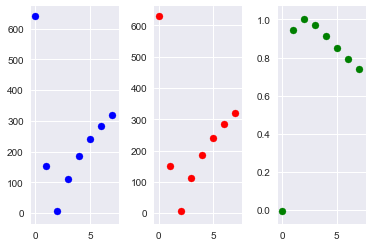

In [181]:
lr = LinearRegression()
from sklearn.mixture import GaussianMixture
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(0,8):
    X_train_new = X_train ** i
    X_test_new = X_test ** i
    
    lr.fit(X_train_new,y_train)

    pred_train = lr.predict(X_train_new)
    pred_test = lr.predict(X_test_new)
    
    RMSE_TRAIN = np.sqrt(mean_squared_error(y_train, pred_train))
    RMSE_TEST = np.sqrt(mean_squared_error(y_test, pred_test))
    R_SQUARED_TEST = lr.score(X_test_new, y_test)
    
    plt.subplot(1, 3, 1) 
    plt.scatter(i, RMSE_TRAIN, label='RMSE_TRAIN',c='b')
    plt.subplot(1, 3, 2)
    plt.scatter(i, RMSE_TEST, label='RMSE_TEST',c='r')
    plt.subplot(1, 3, 3)
    plt.scatter(i, R_SQUARED_TEST, label='R_SQUARED_TEST',c='g')